In [ ]:
!pip install Sastrawi --upgrade

In [ ]:
!pip install transformers
!pip install pycaret

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout

import nltk
import re
from nltk.corpus import stopwords
nltk.download("stopwords")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from collections import Counter

from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## ***Load Dataset***

In [ ]:
# Load Dataset
data = pd.read_csv('600 news with valid hoax label.csv', delimiter=';', encoding='Windows-1254')

# Tampilkan DataFrame dan Jumah kolom dan baris
print(data.shape)
data.head()

(600, 2)


,berita,tagging
0,"Jakarta, Di jejaring sosial, banyak beredar in...",Valid
1,Isu bahwa ikan lele mengandung sel kanker di j...,Valid
2,Bagi penikmat kuliner dengan bahan dasar ikan ...,Valid
3,Ikan lele merupakan salah satu makanan favorit...,Valid
4,Ikan lele merupakan bahan makanan yang cukup p...,Valid


In [ ]:
# Menambahkan label berdasarkan tangging 'Valid' menjadi 0 dan 'Hoax' menjadi 1
data['label'] = data['tagging'].apply(lambda x: 0 if x == 'Valid' else 1)

# Tampilkan DataFrame setelah penambahan
data.tail()

,berita,tagging,label
595,Kabar yang beredar seputar rencana kenaikan ga...,Valid,0
596,Kabar yang beredar seputar rencana kenaikan ga...,Valid,0
597,"Akhir-akhir ini, beredar pemberitaan yang meny...",Valid,0
598,Rancangan peraturan pemerintah (RPP) tentang G...,Valid,0
599,Kabar yang beredar seputar rencana kenaikan ga...,Valid,0


## ***EDA***

0    372
1    228
Name: label, dtype: int64


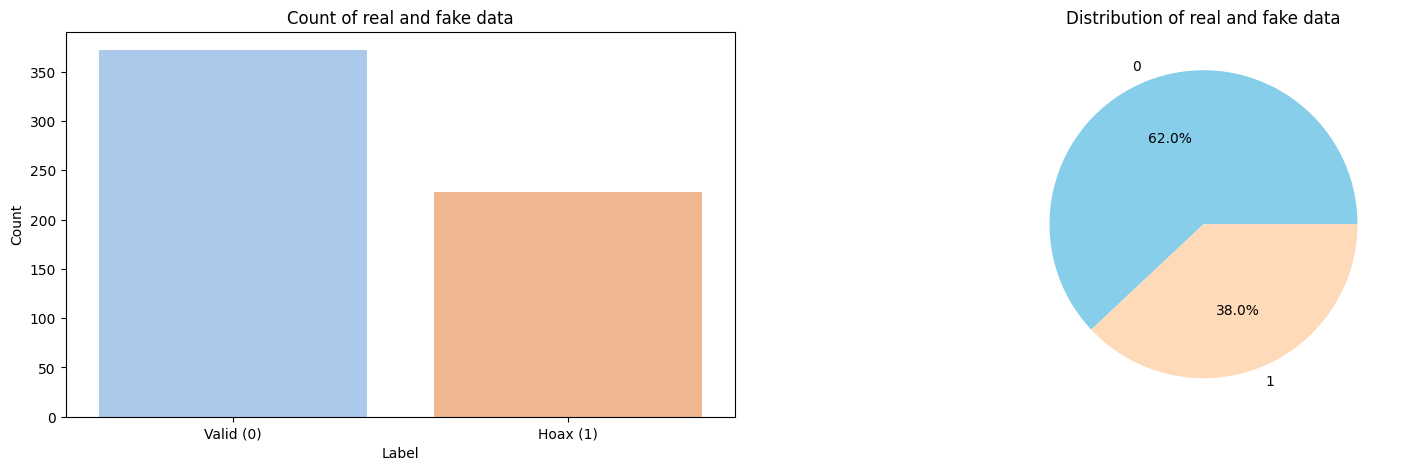

In [ ]:
# Menghitung jumlah valid dan hoax
data['label'] = data['label'].astype(int)
print(data["label"].value_counts())

# Menghitung jumlah masing-masing nilai
counts = data['label'].value_counts()

# Membuat subplots
fig, ax = plt.subplots(1, 2, figsize=(19, 5))

# Count plot
g1 = sns.barplot(x=counts.index, y=counts.values, palette="pastel", ax=ax[0])
g1.set_title("Count of real and fake data")
g1.set_ylabel("Count")
g1.set_xlabel("Label")
g1.set_xticks([0, 1])
g1.set_xticklabels(['Valid (0)', 'Hoax (1)'])
g1.set_xlim(-0.5, 1.5)

# Piechart
g2 = ax[1].pie(data["label"].value_counts(), explode=[0, 0], labels=data["label"].value_counts().index, autopct='%1.1f%%', colors=['SkyBlue', 'PeachPuff'])
ax[1].set_title("Distribution of real and fake data")

plt.show()

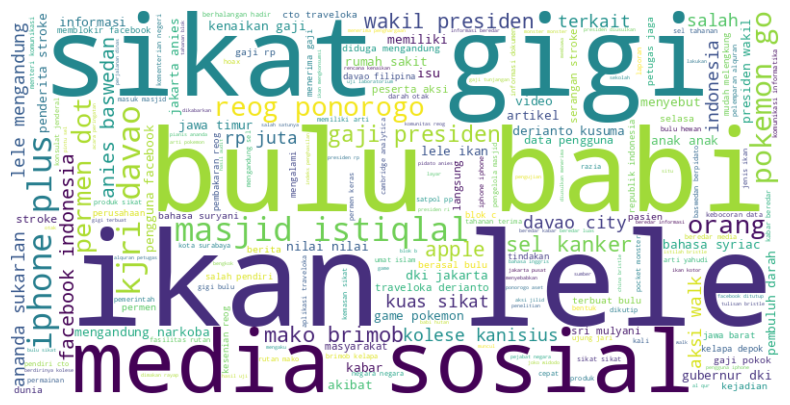

In [ ]:
# Wordcloud
data_berita = data['berita']

# Gabungkan semua string dari dataset
joined_text = " ".join(str(word) for word in data_berita)

# Buang tanda baca dan ubah ke lowercase
cleaned_text = "".join(c if c.isalnum() or c.isspace() else " " for c in joined_text)
cleaned_text = cleaned_text.lower()

# Tentukan stopwords dengan standar library Sastrawi
sastrawi_stopword_remover = StopWordRemoverFactory()
sastrawi_stopwords = sastrawi_stopword_remover.get_stop_words()

# Menambahkan stopwords yang menurut kita
personalized_stopwords_file = "stopword_list_tala.txt"
with open(personalized_stopwords_file, "r") as file:
    personalized_stopwords = [line.strip() for line in file]

# Gabungkan stopwords Sastrawi dengan stopwords yang dipersonalisasi
combined_stopwords = set(sastrawi_stopwords).union(personalized_stopwords)

# Hapus stopwords menggunakan daftar stopwords gabungan
cleaned_text_no_stopwords = " ".join(word for word in cleaned_text.split() if word not in combined_stopwords)

# Hapus karakter dan tanda baca non-alfanumerik
cleaned_text_no_special_chars = re.sub(r'[^a-zA-Z\s]', '', cleaned_text_no_stopwords)

# Hapus nilai numerik
cleaned_text_no_numerical = " ".join(word for word in cleaned_text_no_special_chars.split() if not word.isdigit())

# Generate wordcloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(cleaned_text_no_numerical)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

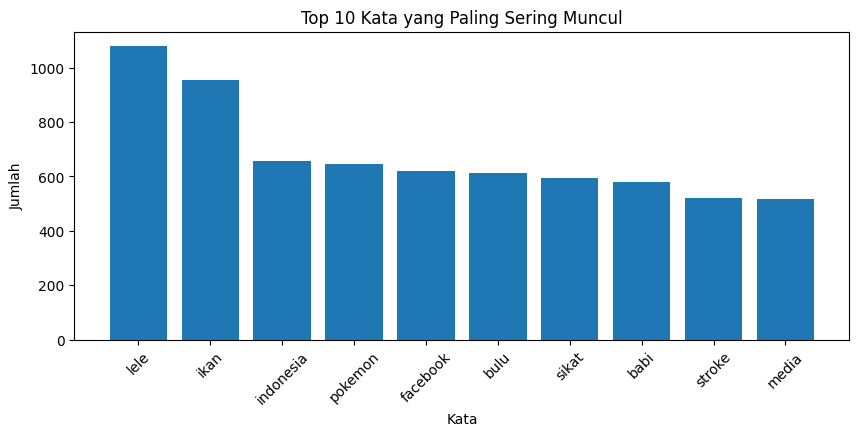

In [ ]:
# Tokenize teks tadi untuk mendapatkan kata-kata individual
words = cleaned_text_no_numerical.split()

# Hitung frekuensi setiap kata
word_freq = Counter(words)

# Urutkan kata-kata berdasarkan frekuensinya dalam urutan menurun
sorted_word_freq = word_freq.most_common()

# Pilih 10 kata teratas
top_words = dict(sorted_word_freq[:10])

# Plot
plt.figure(figsize=(10, 4))
plt.bar(top_words.keys(), top_words.values())
plt.xlabel('Kata')
plt.ylabel('Jumlah')
plt.title('Top 10 Kata yang Paling Sering Muncul')
plt.xticks(rotation=45)
plt.show()

<AxesSubplot: xlabel='count', ylabel='word'>

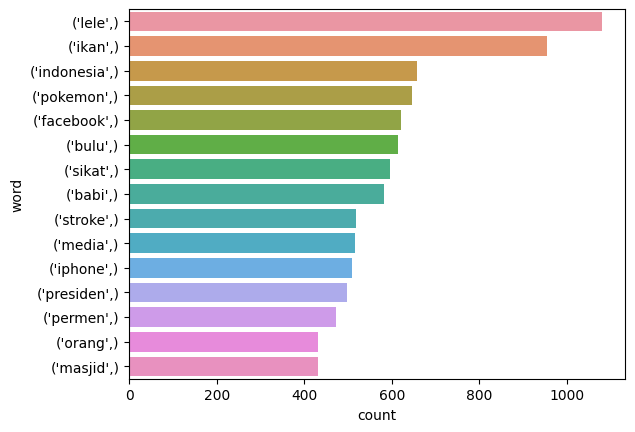

<Figure size 1600x900 with 0 Axes>

In [ ]:
def draw_n_gram(string,i):
    n_gram = (pd.Series(nltk.ngrams(string, i)).value_counts())[:15]
    n_gram_df=pd.DataFrame(n_gram)
    n_gram_df = n_gram_df.reset_index()
    n_gram_df = n_gram_df.rename(columns={"index": "word", 0: "count"})
    fig = sns.barplot(x='count',y='word', data=n_gram_df)
    plt.figure(figsize = (16,9))
    return fig

draw_n_gram(words,1)

<AxesSubplot: xlabel='count', ylabel='word'>

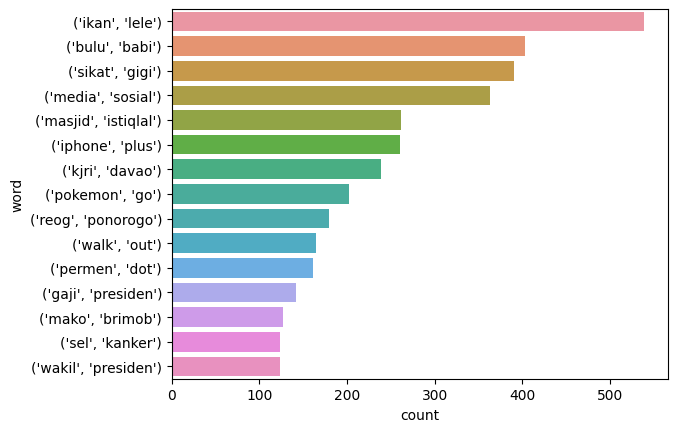

<Figure size 1600x900 with 0 Axes>

In [ ]:
draw_n_gram(words,2)

<AxesSubplot: xlabel='count', ylabel='word'>

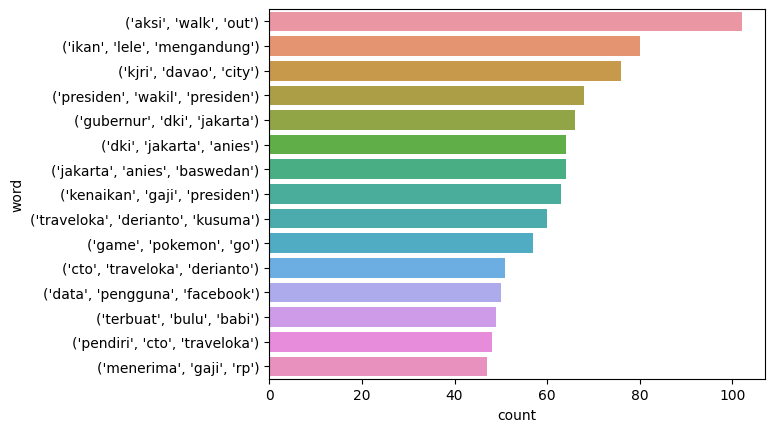

<Figure size 1600x900 with 0 Axes>

In [ ]:
draw_n_gram(words,3)

## ***Preprocessing***

In [ ]:
### Dataset Preprocessing
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

corpus = []
for i in range(0, len(data)):
    print(i)
    review = re.sub('[^a-zA-Z]', ' ', data['berita'][i])
    review = review.lower()
    review = review.split()

    review = [ps.stem(word) for word in review if not word in stopwords.words('indonesian')]
    review = ' '.join(review)
    corpus.append(review)
corpus

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

['jakarta jejar sosial beredar informasi menyebut lele ikan jorok sesuap dage ikan lele terkandung sel kanker julukan ikan jorok merujuk sifat lele doyan mengonsumsi jeni limbah perairan artikel viral internet kotoran manusia dijadikan pakan budidaya lele kota haikou china habitat aslinya lele catfish diken spesi ikan tangguh ikan dilengkapi alat pernapasan tambahan labirin bertahan hidup kondisi perairan berlumpur tercemar fakta memunculkan dugaan akumulasi racun karsinogen penyebab kanker tubuh ikan lele untungnya ikan lele beredar pasaran beras alam liar lele dibudidayakan kolam kolam mestinya dikendalikan beba pencemaran pakan dipilih mengandalkan limbah popularita ikan bersungut pudar meningkat data kementerian kelautan perikanan kkp menyebut produksi lele mencapai ton meningkat ton ton konsumsi ikan lele badan pusat statistik bp tercatat kg kapita kg kapita jakarta lapak pecel lele terdaftar asosiasi pedagang kaki indonesia apkli kandungan nutrisi dipungkiri lele sumber protein b

In [ ]:
voc_size=5000
onehot_repr=[one_hot(words,voc_size)for words in corpus]

In [ ]:
sent_length=20
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[1435  531  811 ... 3865 3692  162]
 [2133 3421 1817 ...  831 3413  797]
 [4555 2698 1995 ... 2133 2165 4555]
 ...
 [2713 4821 4473 ... 1165  897 2100]
 [2352 2706 3240 ... 2352 1904  498]
 [2713 4821 4473 ... 1165  897 2100]]


In [ ]:
embedded_docs[0]

array([1435,  531,  811, 2764, 2133, 3119, 1536,  755, 1800,  210, 2015,
        885, 3771, 2133, 2029, 3391, 4501, 3865, 3692,  162], dtype=int32)

# ***LSTM Bidirectional***

In [ ]:
## Creating model
embedding_vector_features=40
model1=Sequential()
model1.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model1.add(Bidirectional(LSTM(10)))
model1.add(Dropout(0.3))
model1.add(Dense(1,activation='sigmoid'))
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 40)            200000    
                                                                 
 bidirectional (Bidirection  (None, 20)                4080      
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 204101 (797.27 KB)
Trainable params: 204101 (797.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
len(embedded_docs), data['label'].shape

(600, (600,))

In [ ]:
X_final=np.array(embedded_docs)
y_final=np.array(data['label'])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

In [ ]:
### Finally Training
history1 = model1.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
7/7 [==============================] - 6s 193ms/step - loss: 0.6901 - accuracy: 0.5871 - val_loss: 0.6815 - val_accuracy: 0.6869
Epoch 2/10
7/7 [==============================] - 0s 44ms/step - loss: 0.6780 - accuracy: 0.6144 - val_loss: 0.6698 - val_accuracy: 0.6869
Epoch 3/10
7/7 [==============================] - 0s 51ms/step - loss: 0.6651 - accuracy: 0.6020 - val_loss: 0.6569 - val_accuracy: 0.6869
Epoch 4/10
7/7 [==============================] - 0s 47ms/step - loss: 0.6480 - accuracy: 0.5945 - val_loss: 0.6409 - val_accuracy: 0.6869
Epoch 5/10
7/7 [==============================] - 0s 52ms/step - loss: 0.6223 - accuracy: 0.6095 - val_loss: 0.6204 - val_accuracy: 0.6869
Epoch 6/10
7/7 [==============================] - 0s 52ms/step - loss: 0.5872 - accuracy: 0.6592 - val_loss: 0.5964 - val_accuracy: 0.6818
Epoch 7/10
7/7 [==============================] - 0s 48ms/step - loss: 0.5407 - accuracy: 0.7015 - val_loss: 0.5716 - val_accuracy: 0.6919
Epoch 8/10
7/7 [==========

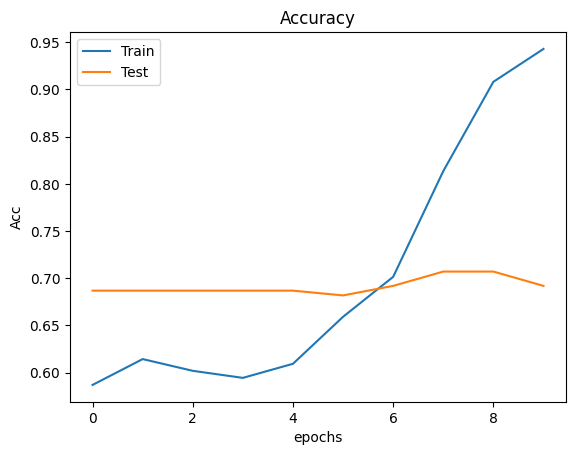

In [ ]:
plt.figure()
plt.plot(history1.history["accuracy"], label = "Train")
plt.plot(history1.history["val_accuracy"], label = "Test")
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

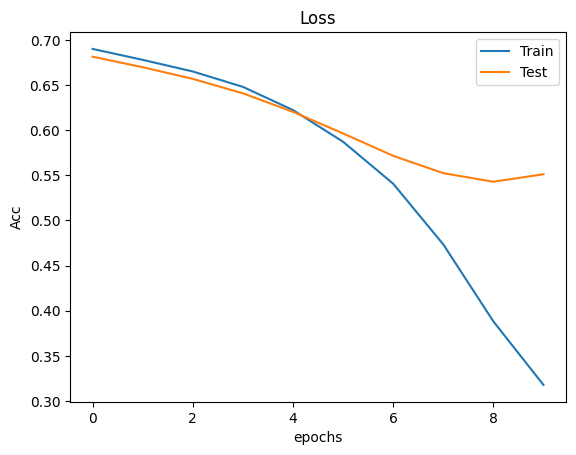

In [ ]:
plt.figure()
plt.plot(history1.history["loss"], label = "Train")
plt.plot(history1.history["val_loss"], label = "Test")
plt.title("Loss")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

In [ ]:
# Mendapatkan probabilitas prediksi untuk set data uji
pred_probabilities = model1.predict(X_test)

# Menggunakan threshold 0.5 untuk mendapatkan kelas prediksi
pred_classes = (pred_probabilities > 0.5).astype('int')

# Menampilkan laporan klasifikasi
print(classification_report(y_test, pred_classes, target_names=['0', '1']))

7/7 [==============================] - 2s 12ms/step
              precision    recall  f1-score   support

           0       0.74      0.86      0.79       136
           1       0.51      0.32      0.40        62

    accuracy                           0.69       198
   macro avg       0.62      0.59      0.59       198
weighted avg       0.67      0.69      0.67       198

